In [87]:
#Import Dependencies
from functions import regress
from functions import linregress
from functions import summarize
import pandas as pd
#Dependencies
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
import pandas as pd
import sklearn
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import numpy as np

<h2>Get the Data</h2>


In [49]:
#Convert data from Stata format to pandas dataframe
gss = pd.io.stata.read_stata('../data/GSS1996.dta',convert_categoricals=False)
itr = pd.read_stata('../data/GSS1996.dta', iterator = True)
gss.to_csv('../data/gss_converted.csv')

<h2>Clean the Data</h2>

In [50]:
#Drop all instances where no vehicle was purchased
gss=gss.dropna(subset=["carprivt"])

In [51]:
#Get list of relevant variable names
full_list=list(gss)
varlist=[]
for item in full_list:
    if item[0:3]=="car":
     varlist.append(item)

morevars=["degree","region","race","childs","sex","marital","satcar","newused", "age"]
for item in morevars:
    varlist.append(item)

In [52]:
#Get varaible labels
labels=itr.variable_labels()
for item in varlist:
    print(f"{item}: {labels[item]}")

carprivt: have you purchased a used car past 5 yrs?
cardealr: purchased a car from a dealership past 5 yrs?
carbuyf: r searched for the best price
carbuya: r's own previous knowledge made r buy
carbuyg: convenience made r buy 
carbuyd: general reputation made r buy
carbuyb: a friend or relative recommended r buy 
carbuyc: an acquaintance recommended r buy
carbuye: r saw their advertisement
carbuy1: what was the most important reason? 
degree: r's highest degree
region: region of interview
race: race of respondent
childs: number of children
sex: respondents sex
marital: marital status
satcar: how satisfied are you with your purchase? 
newused: was the car new or used?
age: age of respondent


In [53]:
#Recode the Variables

#Car Variables
dummylist = ["carprivt", "cardealr", "carbuyf", "carbuya", "carbuyg", "carbuyd", "carbuyb", "carbuyc", "carbuye", "carbuy1","satcar", "newused"]
for item in dummylist:
    gss[f"{item}_r"]=gss[item]
    gss.loc[(gss[item] ==1), f"{item}_r"] = 0
    gss.loc[(gss[item] ==2), f"{item}_r"] = 1

#Control Variables
#Recode sex to dummy, reference category = "female"
gss["sex_r"]=gss["sex"]
gss.loc[gss.sex == 1, 'sex_r'] = 0
gss.loc[gss.sex == 2, 'sex_r'] = 1

#Recode race to dummy, reference category = "nonwhite"
gss["race_r"]=gss["race"]
gss.loc[gss.race == 1, 'race_r'] = 0
gss.loc[gss.race > 1, 'race_r'] = 1

#Recode degree to dummy, reference category = "has no degree" (note that in original study, ref cat was HAS degree)
gss["degree_r"]=gss["degree"]
gss.loc[gss.degree <=3, 'degree_r'] = 0
gss.loc[gss.degree > 3, 'degree_r'] = 1

#Recode region to dummy, reference category = "Not from South"
gss["region_r"]=gss["region"]
gss.loc[(gss.region <=4) | (gss.region >7), 'region_r'] = 0
gss.loc[(gss.region >=5) & (gss.region <=7), 'region_r'] = 1

#Recode marital to new categorical variable with reference category = "single, never married" and divorced and separated categories combined (note that this differs slightly from the original study, which did not assign "0" to any value of the variable.)
#New categories:
#0=single, never married
#1=married
#2=divorced/separated
#3=widowed
gss["marital_r"]=gss["marital"]
gss.loc[(gss.marital ==5), 'marital_r'] = 0
gss.loc[(gss.marital ==4) | (gss.marital ==3), 'marital_r'] = 2
gss.loc[(gss.marital ==3), 'marital_r'] = 3

#Recode parent to dummy, reference category = "is not parent"
gss["childs_r"]=gss["childs"]
gss.loc[(gss.childs >0), 'childs_r'] = 1

#Center the age variable
gss["age_c"]=gss["age"]-gss["age"].mean()

In [54]:
newvars=['carprivt_r', 'cardealr_r', 'carbuyf_r', 'carbuya_r', 'carbuyg_r', 'carbuyd_r', 'carbuyb_r', 'carbuyc_r', 'carbuye_r', 'carbuy1_r', 'degree_r', 'region_r', 'race_r', 'childs_r', 'sex_r', 'marital_r', 'satcar_r', 'newused_r', 'age_c']
reduced=pd.DataFrame()
for item in newvars:
    reduced[item]=gss[item]




CARPRIVT_R



count    735.000000
mean       0.659864
std        0.474077
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carprivt_r, dtype: float64


Obs per category
------------------
0.0-> 250 (34.01%)
1.0-> 485 (65.99%)


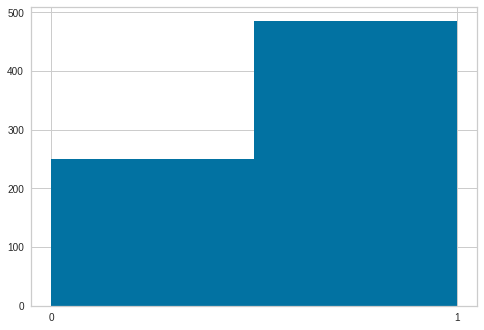

(array([250., 485.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARDEALR_R



count    728.000000
mean       0.451923
std        0.498025
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: cardealr_r, dtype: float64


Obs per category
------------------
0.0-> 399 (54.29%)
1.0-> 329 (44.76%)


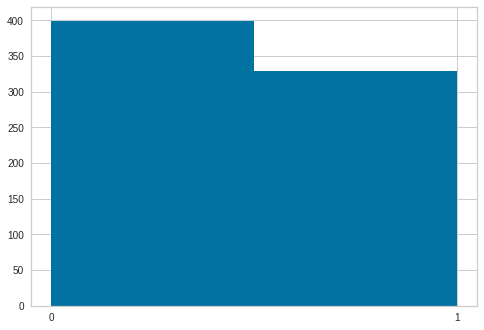

(array([399., 329.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYF_R



count    334.000000
mean       0.497006
std        0.500741
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: carbuyf_r, dtype: float64


Obs per category
------------------
0.0-> 168 (22.86%)
1.0-> 166 (22.59%)


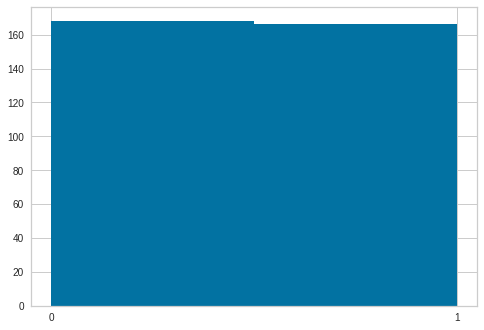

(array([168., 166.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYA_R



count    330.000000
mean       0.612121
std        0.488007
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuya_r, dtype: float64


Obs per category
------------------
0.0-> 128 (17.41%)
1.0-> 202 (27.48%)


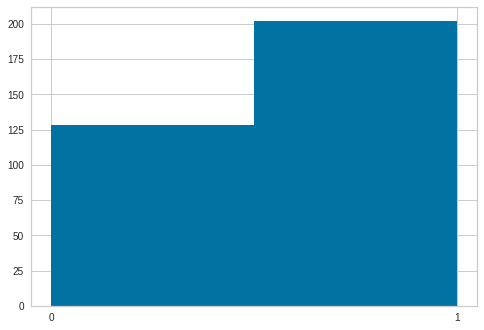

(array([128., 202.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYG_R



count    324.000000
mean       0.626543
std        0.484470
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuyg_r, dtype: float64


Obs per category
------------------
0.0-> 121 (16.46%)
1.0-> 203 (27.62%)


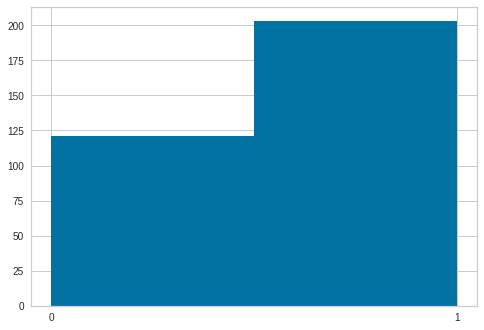

(array([121., 203.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYD_R



count    316.000000
mean       0.661392
std        0.473987
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuyd_r, dtype: float64


Obs per category
------------------
0.0-> 107 (14.56%)
1.0-> 209 (28.44%)


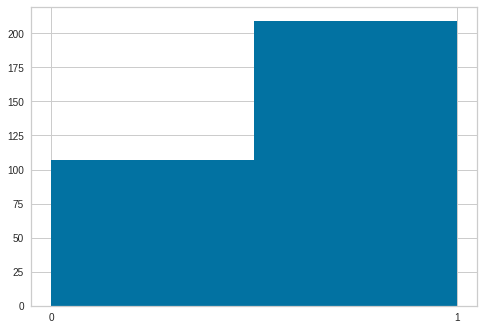

(array([107., 209.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYB_R



count    315.000000
mean       0.647619
std        0.478472
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuyb_r, dtype: float64


Obs per category
------------------
0.0-> 111 (15.1%)
1.0-> 204 (27.76%)


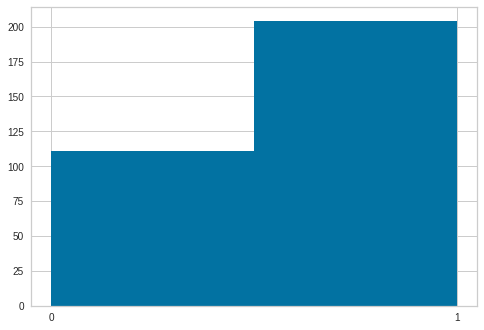

(array([111., 204.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYC_R



count    305.000000
mean       0.875410
std        0.330796
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuyc_r, dtype: float64


Obs per category
------------------
0.0-> 38 (5.17%)
1.0-> 267 (36.33%)


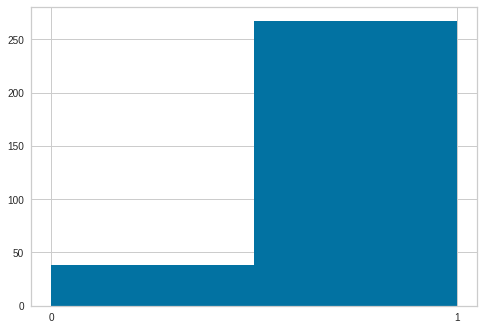

(array([ 38., 267.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYE_R



count    305.000000
mean       0.740984
std        0.438815
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuye_r, dtype: float64


Obs per category
------------------
0.0-> 79 (10.75%)
1.0-> 226 (30.75%)


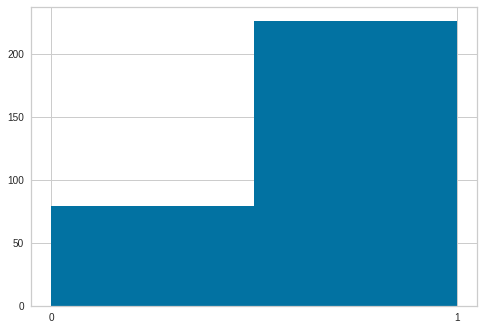

(array([ 79., 226.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUY1_R



count    186.000000
mean       3.994624
std        2.587908
min        0.000000
25%        1.000000
50%        5.500000
75%        6.000000
max        7.000000
Name: carbuy1_r, dtype: float64


Obs per category
------------------
0.0-> 35 (4.76%)
1.0-> 23 (3.13%)
3.0-> 5 (0.68%)
4.0-> 20 (2.72%)
5.0-> 10 (1.36%)
6.0-> 76 (10.34%)
7.0-> 17 (2.31%)


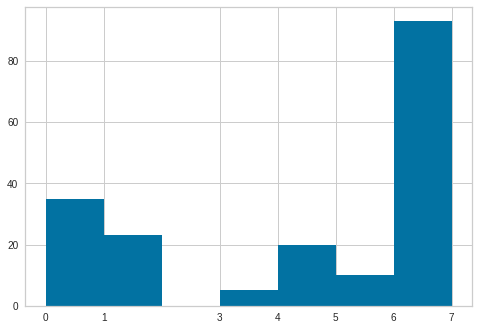

(array([35., 23.,  0.,  5., 20., 10., 93.]), array([0., 1., 2., 3., 4., 5., 6., 7.]), <BarContainer object of 7 artists>)



DEGREE_R



count    731.000000
mean       0.073871
std        0.261741
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: degree_r, dtype: float64


Obs per category
------------------
0.0-> 677 (92.11%)
1.0-> 54 (7.35%)


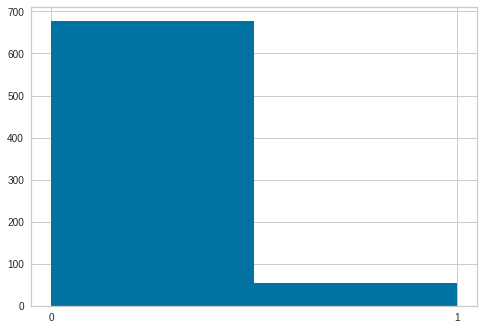

(array([677.,  54.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



REGION_R



count    735.000000
mean       0.346939
std        0.476320
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: region_r, dtype: float64


Obs per category
------------------
0-> 480 (65.31%)
1-> 255 (34.69%)


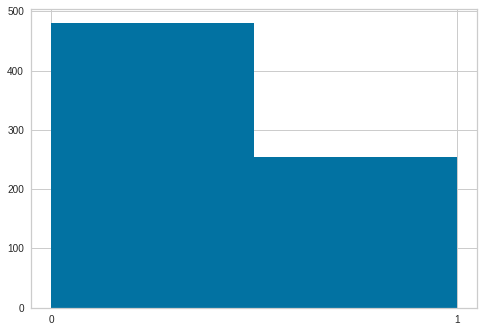

(array([480., 255.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



RACE_R



count    735.000000
mean       0.200000
std        0.400272
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: race_r, dtype: float64


Obs per category
------------------
0-> 588 (80.0%)
1-> 147 (20.0%)


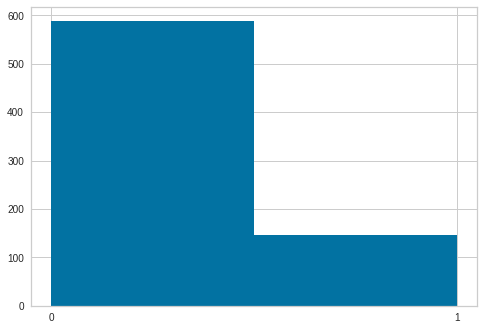

(array([588., 147.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CHILDS_R



count    731.000000
mean       0.715458
std        0.451505
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: childs_r, dtype: float64


Obs per category
------------------
0.0-> 208 (28.3%)
1.0-> 523 (71.16%)


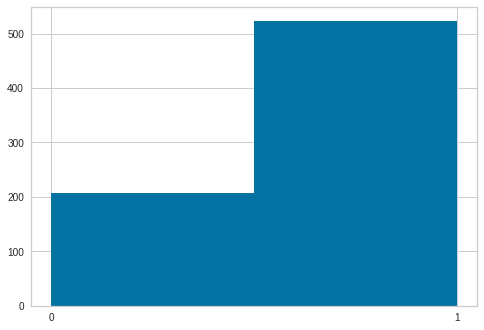

(array([208., 523.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



SEX_R



count    735.000000
mean       0.538776
std        0.498834
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: sex_r, dtype: float64


Obs per category
------------------
0-> 339 (46.12%)
1-> 396 (53.88%)


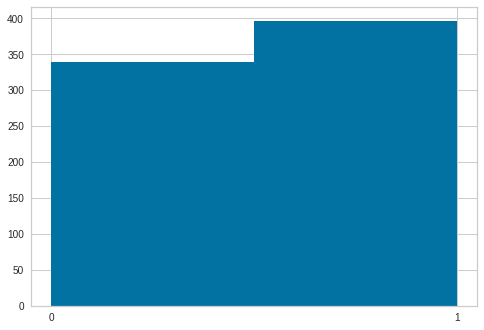

(array([339., 396.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



MARITAL_R



count    735.000000
mean       1.221769
std        0.971566
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: marital_r, dtype: float64


Obs per category
------------------
0.0-> 165 (22.45%)
1.0-> 360 (48.98%)
2.0-> 92 (12.52%)
3.0-> 118 (16.05%)


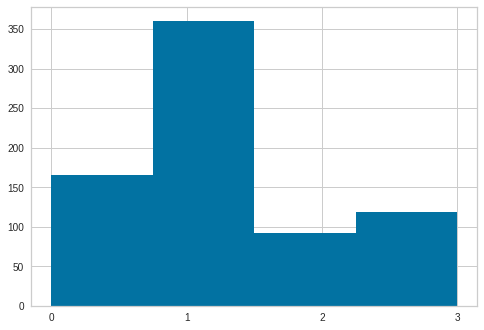

(array([165., 360.,  92., 118.]), array([0.  , 0.75, 1.5 , 2.25, 3.  ]), <BarContainer object of 4 artists>)



SATCAR_R



count    396.000000
mean       1.934343
std        1.127665
min        0.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: satcar_r, dtype: float64


Obs per category
------------------
0.0-> 36 (4.9%)
1.0-> 157 (21.36%)
3.0-> 203 (27.62%)


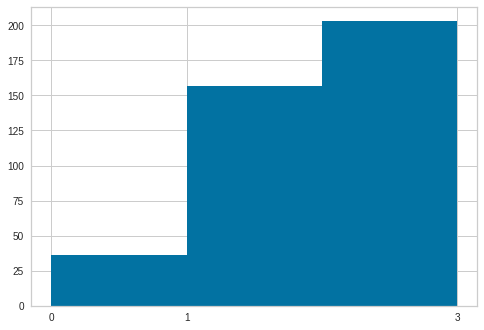

(array([ 36., 157., 203.]), array([0., 1., 2., 3.]), <BarContainer object of 3 artists>)



NEWUSED_R



count    400.000000
mean       0.477500
std        0.500119
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: newused_r, dtype: float64


Obs per category
------------------
0.0-> 209 (28.44%)
1.0-> 191 (25.99%)


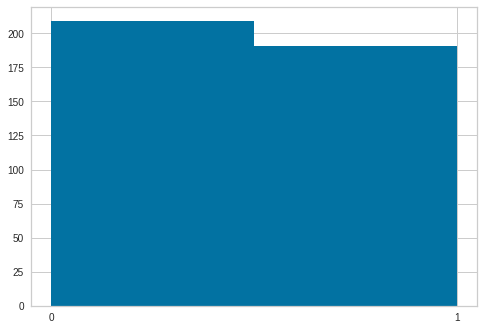

(array([209., 191.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



AGE_C



count    7.350000e+02
mean    -1.759439e-15
std      1.697333e+01
min     -2.699864e+01
25%     -1.299864e+01
50%     -2.998639e+00
75%      1.100136e+01
max      4.400136e+01
Name: age_c, dtype: float64




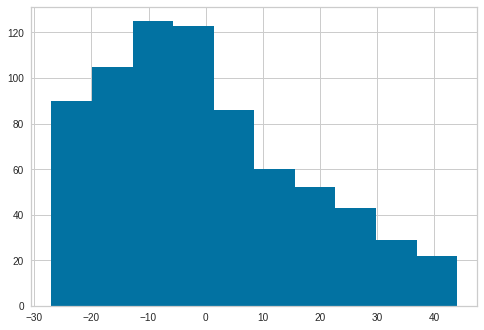

(array([ 90., 105., 125., 123.,  86.,  60.,  52.,  43.,  29.,  22.]), array([-26.99863946, -19.89863946, -12.79863946,  -5.69863946,
         1.40136054,   8.50136054,  15.60136054,  22.70136054,
        29.80136054,  36.90136054,  44.00136054]), <BarContainer object of 10 artists>)


In [55]:
#Get summary statistics and histogram for all variables
for item in newvars:
    print("\n"*2)
    print(item.upper())
    print("\n"*2)
    summarize(reduced, item)

In [56]:
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [57]:
#multiply impute the data to prep it for logistic regression analysis
reduced_copy=reduced.copy(deep=True)
X_filled_knn = KNN(k=3).fit_transform(reduced_copy)
reduced_mi=pd.DataFrame(X_filled_knn, columns=reduced_copy.columns)
reduced_mi.to_csv("../data/reduced_mi.csv")

Imputing row 1/735 with 10 missing, elapsed time: 0.272
Imputing row 101/735 with 10 missing, elapsed time: 0.294
Imputing row 201/735 with 10 missing, elapsed time: 0.333
Imputing row 301/735 with 7 missing, elapsed time: 0.373
Imputing row 401/735 with 10 missing, elapsed time: 0.406
Imputing row 501/735 with 10 missing, elapsed time: 0.433
Imputing row 601/735 with 7 missing, elapsed time: 0.460
Imputing row 701/735 with 10 missing, elapsed time: 0.480


In [58]:
#Read the CSV back in to avoid re-running the imputer later
reduced_mi=pd.read_csv("../data/reduced_mi.csv")

Optimization terminated successfully.
         Current function value: 0.630640
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.01636
Time:                        03:00:11   Log-Likelihood:                -463.52
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                  0.003915
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8448      0.198      4.274      0.000       0.457       1.232
sex_r          0.450

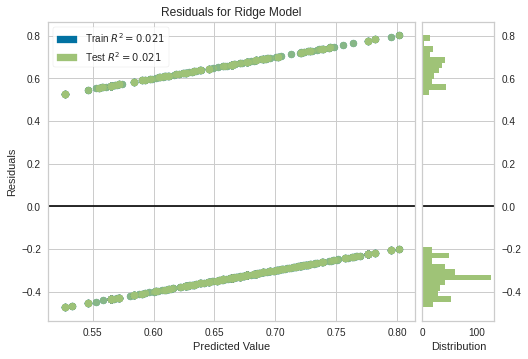

In [24]:
linregress(reduced_mi, "carprivt_r", "sex_r", "race_r", "marital_r", "carbuya_r")

In [22]:
from statsmodels.sandbox.predict_functional import predict_functional
#values = {"Sex1": "Female", "Sex":0, "AHD": 1, "Chol": 250}
pr, cb, fv = predict_functional(result, "age_c", ci_method="simultaneous")
ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Sex")
ax.set_ylabel("dv")

/home/ygael/anaconda3/envs/DataViz/lib/python3.8/site-packages/statsmodels/sandbox/predict_functional.py:169: ValueWarning: 'marital_r', 'newused_r', 'cardealr_r', 'satcar_r', 'degree_r', 'carbuyf_r', 'race_r', 'carbuyd_r', 'carbuyc_r', 'carbuya_r', 'region_r', 'sex_r', 'carbuyg_r', 'carbuy1_r', 'carbuye_r', 'carbuyb_r', 'childs_r' in data frame but not in summaries or values.
  warnings.warn("%s in data frame but not in summaries or values."


PatsyError: Error evaluating factor: NameError: name 'sex_r' is not defined
    carprivt_r ~ sex_r
                 ^^^^^

In [ ]:
gss_k3=gss_recoded.copy(deep=True)
X_filled_knn = KNN(k=3).fit_transform(gss_k3)
gss_knn=pd.DataFrame(X_filled_knn, columns=gss_recoded.columns)
gss_knn.to_csv("../data/gss_fancyimpute_knn.csv")

In [11]:
def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot

    
    model = Ridge()

    visualizer = ResidualsPlot(model, fit=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure

    #predictions = model.predict(x)
    #plt.scatter(predictions, predictions - y, color='coral',linewidths=0.5)
    #plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), color='brown', linewidth=3)
    #plt.show()




Optimization terminated successfully.
         Current function value: 0.630640
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.01636
Time:                        04:51:26   Log-Likelihood:                -463.52
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                  0.003915
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8448      0.198      4.274      0.000       0.457       1.232
sex_r          0.450

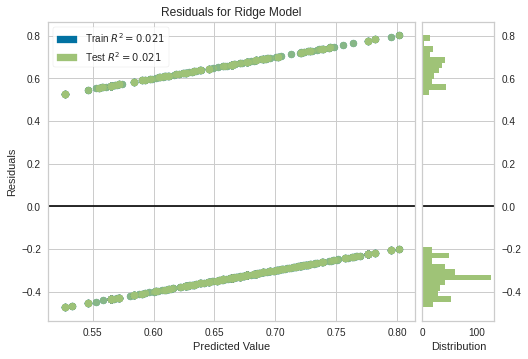

In [12]:
linregress(reduced_mi, "carprivt_r", "sex_r", "race_r", "marital_r", "carbuya_r")

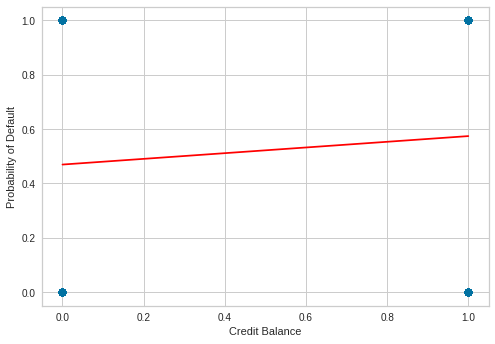

In [29]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
x=reduced_mi["carprivt_r"].values.reshape(-1,1)
y=reduced_mi["sex_r"].values.reshape(-1,1)

LogR = LogisticRegression()
LogR.fit(x,np.ravel(y.astype(int)))



plt.scatter(x,y)
plt.xlabel("Credit Balance")
plt.ylabel("Probability of Default")

plt.plot(x, LogR.predict_proba(x)[:,1], color='red')


<AxesSubplot:xlabel='carprivt_r', ylabel='carbuya_r'>

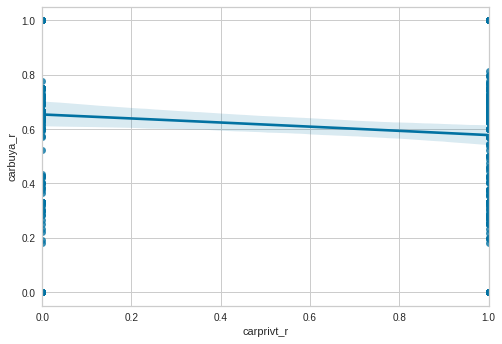

In [46]:
import seaborn as sns
sns.regplot(x='carprivt_r', y='carbuya_r', data=reduced_mi, logistic=True)

In [43]:
def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot
    
    model = Ridge()

    visualizer = ResidualsPlot(model, hist=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()   

    from sklearn.linear_model import LogisticRegression
    x=x.values.reshape(-1,1)
    y=y.values.reshape(-1,1)

    LogR = LogisticRegression()
    LogR.fit(x,np.ravel(y.astype(int)))



    plt.scatter(x,y)
    plt.xlabel("Credit Balance")
    plt.ylabel("Probability of Default")

    plt.plot(x, LogR.predict_proba(x)[:,1], color='red')

Optimization terminated successfully.
         Current function value: 0.630640
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                            4
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.01636
Time:                        05:22:00   Log-Likelihood:                -463.52
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                  0.003915
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8448      0.198      4.274      0.000       0.457       1.232
sex_r          0.450

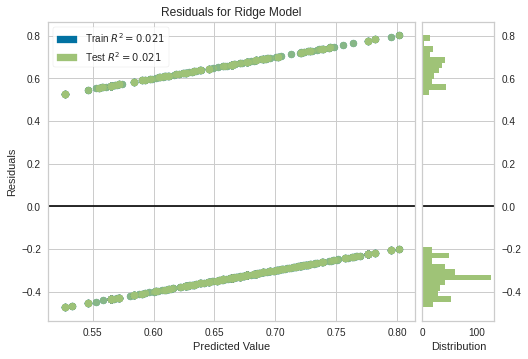

ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [44]:
linregress(reduced_mi, "carprivt_r", "sex_r", "race_r", "marital_r", "carbuya_r")

In [62]:
def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot
    
    model = Ridge()

    visualizer = ResidualsPlot(model, hist=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()   

In [63]:
ivs=[item for item in newvars]
ivs.remove("carprivt_r")

Optimization terminated successfully.
         Current function value: 0.636862
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.006650
Time:                        05:46:52   Log-Likelihood:                -468.09
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                   0.01230
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8462      0.109      7.773      0.000       0.633       1.060
cardealr_r    -0.392

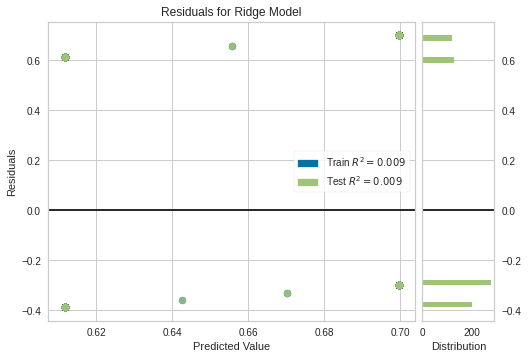

Optimization terminated successfully.
         Current function value: 0.640953
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0002693
Time:                        05:46:55   Log-Likelihood:                -471.10
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.6144
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6152      0.122      5.043      0.000       0.376       0.854
carbuyf_r      0.096

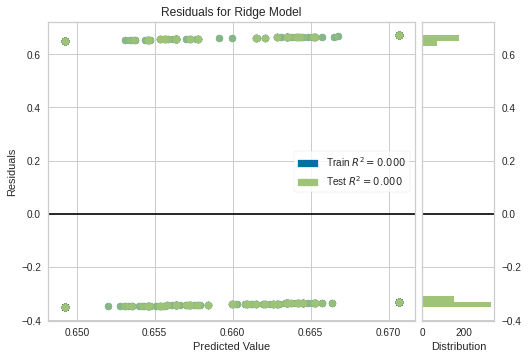

Optimization terminated successfully.
         Current function value: 0.637016
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.006410
Time:                        05:46:58   Log-Likelihood:                -468.21
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                   0.01398
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9627      0.148      6.503      0.000       0.673       1.253
carbuya_r     -0.486

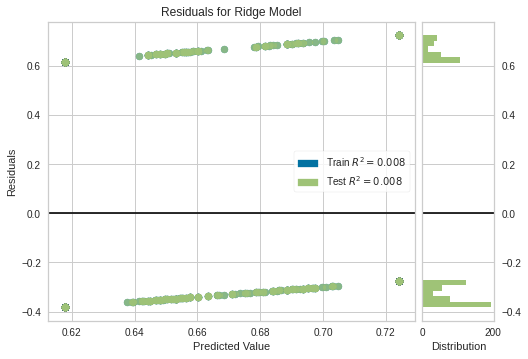

Optimization terminated successfully.
         Current function value: 0.641118
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               1.209e-05
Time:                        05:47:01   Log-Likelihood:                -471.22
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.9150
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6492      0.149      4.371      0.000       0.358       0.940
carbuyg_r      0.021

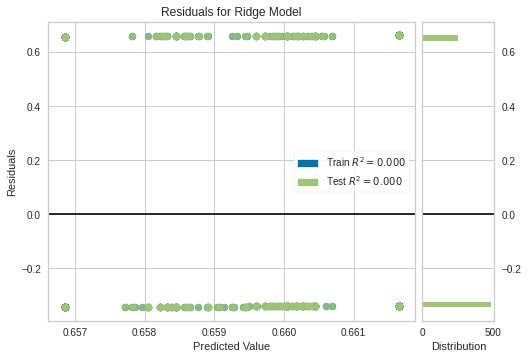

Optimization terminated successfully.
         Current function value: 0.638727
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.003741
Time:                        05:47:03   Log-Likelihood:                -469.46
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                   0.06041
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9269      0.164      5.664      0.000       0.606       1.248
carbuyd_r     -0.396

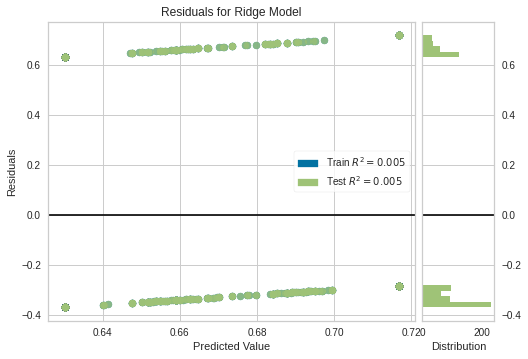

Optimization terminated successfully.
         Current function value: 0.640974
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0002365
Time:                        05:47:05   Log-Likelihood:                -471.12
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.6368
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7253      0.154      4.701      0.000       0.423       1.028
carbuyb_r     -0.095

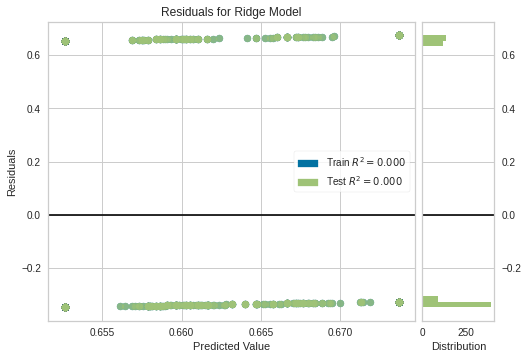

Optimization terminated successfully.
         Current function value: 0.641120
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               8.908e-06
Time:                        05:47:07   Log-Likelihood:                -471.22
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.9270
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6390      0.269      2.374      0.018       0.111       1.167
carbuyc_r      0.027

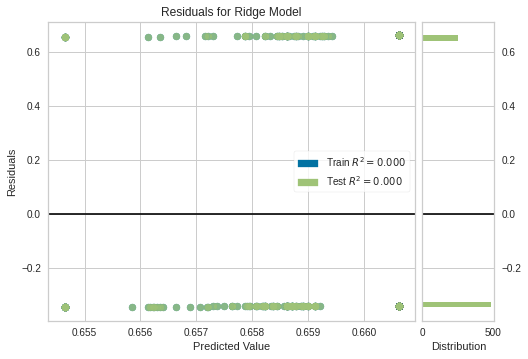

Optimization terminated successfully.
         Current function value: 0.641094
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               4.991e-05
Time:                        05:47:09   Log-Likelihood:                -471.20
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.8283
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6998      0.188      3.717      0.000       0.331       1.069
carbuye_r     -0.049

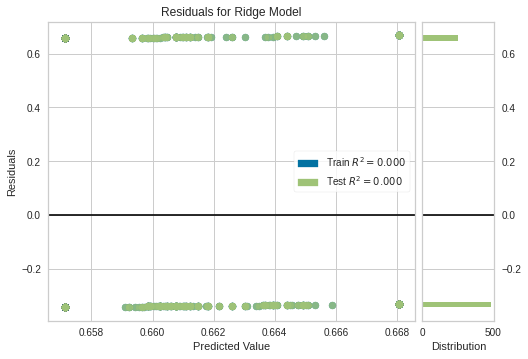

Optimization terminated successfully.
         Current function value: 0.631300
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.01533
Time:                        05:47:12   Log-Likelihood:                -464.01
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                 0.0001444
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2751      0.186      6.851      0.000       0.910       1.640
carbuy1_r     -0.152

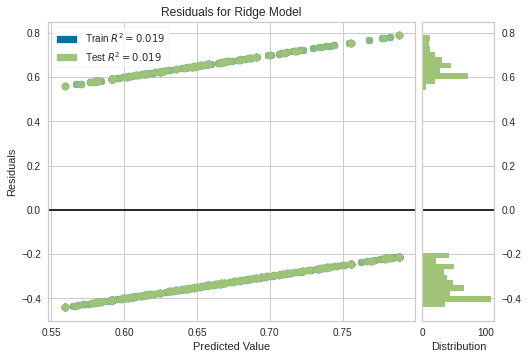

Optimization terminated successfully.
         Current function value: 0.640871
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0003978
Time:                        05:47:14   Log-Likelihood:                -471.04
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.5403
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6493      0.081      8.040      0.000       0.491       0.808
degree_r       0.185

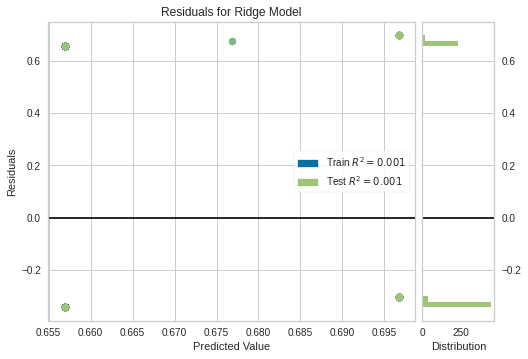

Optimization terminated successfully.
         Current function value: 0.640716
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0006392
Time:                        05:47:18   Log-Likelihood:                -470.93
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.4377
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6190      0.096      6.469      0.000       0.431       0.807
region_r       0.127

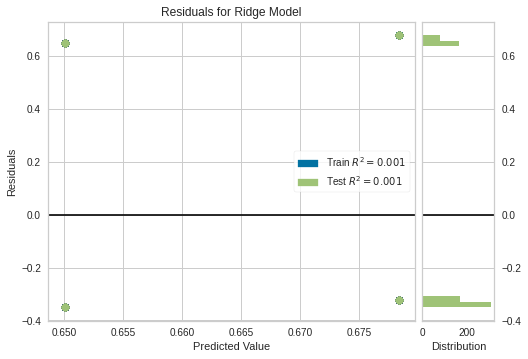

Optimization terminated successfully.
         Current function value: 0.641022
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               0.0001616
Time:                        05:47:21   Log-Likelihood:                -471.15
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.6963
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6476      0.087      7.457      0.000       0.477       0.818
race_r         0.076

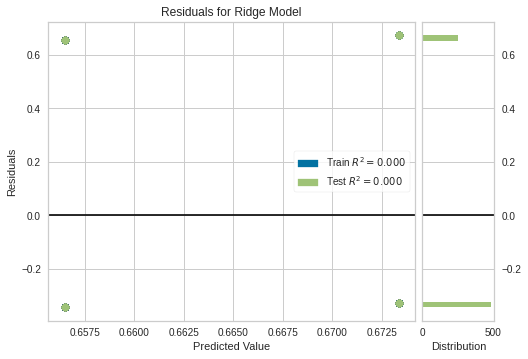

Optimization terminated successfully.
         Current function value: 0.641063
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:               9.713e-05
Time:                        05:47:24   Log-Likelihood:                -471.18
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.7622
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7004      0.147      4.756      0.000       0.412       0.989
childs_r      -0.052

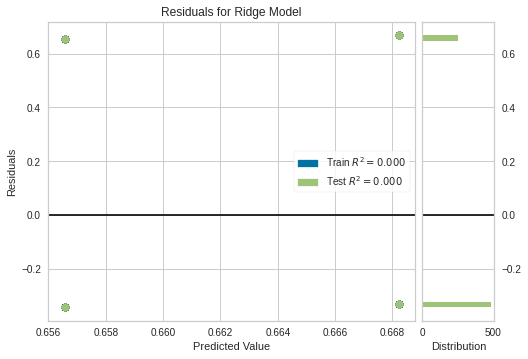

Optimization terminated successfully.
         Current function value: 0.635936
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.008095
Time:                        05:47:29   Log-Likelihood:                -467.41
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                  0.005743
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4375      0.111      3.933      0.000       0.220       0.656
sex_r          0.431

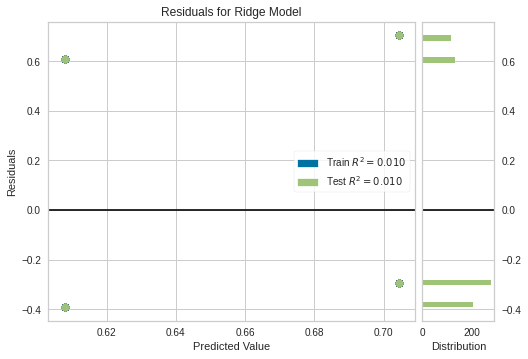

Optimization terminated successfully.
         Current function value: 0.640439
         Iterations 4
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.001071
Time:                        05:47:31   Log-Likelihood:                -470.72
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                    0.3150
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7617      0.126      6.035      0.000       0.514       1.009
marital_r     -0.080

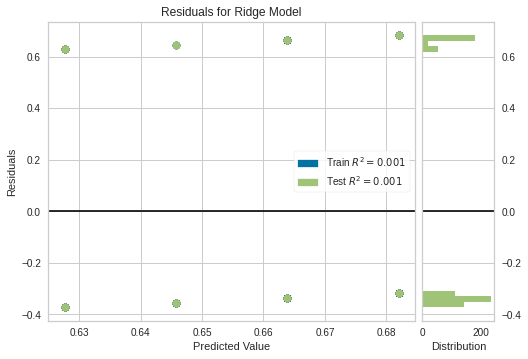

Optimization terminated successfully.
         Current function value: 0.637340
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                0.005905
Time:                        05:47:34   Log-Likelihood:                -468.44
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                   0.01832
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2879      0.175      1.643      0.100      -0.056       0.631
satcar_r       0.193

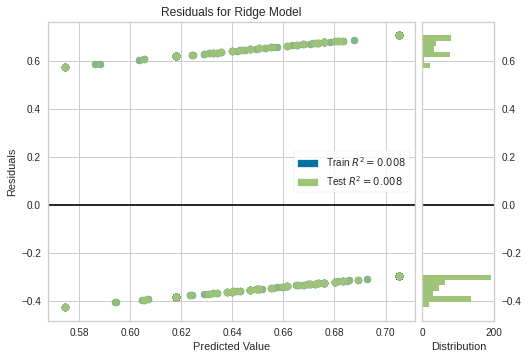

Optimization terminated successfully.
         Current function value: 0.622133
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.02962
Time:                        05:47:37   Log-Likelihood:                -457.27
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                 1.264e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1661      0.129      9.024      0.000       0.913       1.419
newused_r     -0.986

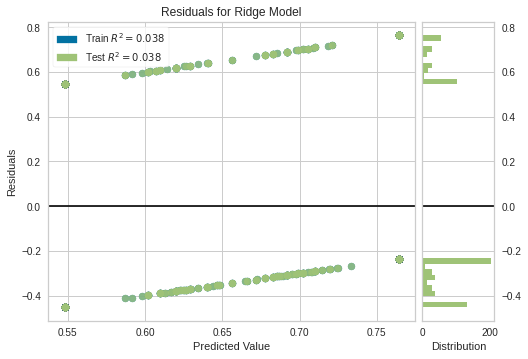

Optimization terminated successfully.
         Current function value: 0.610746
         Iterations 5
LOG ODDS
                           Logit Regression Results                           
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Mar 2021   Pseudo R-squ.:                 0.04739
Time:                        05:47:41   Log-Likelihood:                -448.90
converged:                       True   LL-Null:                       -471.23
Covariance Type:            nonrobust   LLR p-value:                 2.345e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7170      0.082      8.737      0.000       0.556       0.878
age_c          0.033

KeyboardInterrupt: 

In [80]:
for item in ivs:
    linregress(reduced_mi, "carprivt_r", item)

In [75]:
satreduced=gss.dropna(subset=["satcar"])

In [74]:
#multiply impute the data to prep it for logistic regression analysis
gss_copy=gss.copy(deep=True)
X_filled_knn = KNN(k=3).fit_transform(gss_copy)
gss_mi=pd.DataFrame(X_filled_knn, columns=gss_copy.columns)
gss_mi.to_csv("../data/reduced_mi.csv")

Imputing row 1/735 with 672 missing, elapsed time: 19.170
Imputing row 101/735 with 648 missing, elapsed time: 20.708
Imputing row 201/735 with 639 missing, elapsed time: 22.270
Imputing row 301/735 with 638 missing, elapsed time: 23.764
Imputing row 401/735 with 638 missing, elapsed time: 25.232
Imputing row 501/735 with 659 missing, elapsed time: 26.841
Imputing row 601/735 with 652 missing, elapsed time: 28.345
Imputing row 701/735 with 624 missing, elapsed time: 29.866
[KNN] Warning: 249900/833490 still missing after imputation, replacing with 0


In [76]:
gss_mi=pd.read_csv("../data/gss_fancyimpute_knn.csv")

In [ ]:
linregress(gss_mi, "satcar", "sex_r")

In [88]:
def linregress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import numpy as np

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y]
    #fit the model
    model.fit(x,y)
    
    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Fit the Model
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    logit = sm.Logit(Y, X)
    logit_result = logit.fit()

    #Print Log Odds
    print("LOG ODDS")
    print(logit_result.summary())
    print(np.exp(logit_result.params))

    #Plot the Residuals
    print("\n Residual Plot")
    from sklearn.linear_model import Ridge
    from yellowbrick.datasets import load_concrete
    from yellowbrick.regressor import ResidualsPlot
    
    model = Ridge()

    visualizer = ResidualsPlot(model, hist=True)
    y2= y.values.reshape(-1, 1)
    visualizer.fit(x, y2)  # Fit the training data to the visualizer
    visualizer.score(x, y2)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure


In [100]:
import matplotlib.pyplot as plt
from functions import regress
reduced=gss_mi.dropna(subset=["satcar"])
regress(reduced,"satcar","sex")

                            OLS Regression Results                            
Dep. Variable:                 satcar   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Mar 2021   Prob (F-statistic):                nan
Time:                        05:56:40   Log-Likelihood:                    inf
No. Observations:                1114   AIC:                              -inf
Df Residuals:                    1112   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0          0        nan        n

NameError: name 'plt' is not defined

In [96]:
def regress(*args):
    #import dependencies
    import sklearn as sk
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    from sklearn import feature_selection
    import statsmodels.api as sm
    from patsy import dmatrices
    import matplotlib.pyplot as plt

    #define arguments
    dataframe=args[0]
    y=args[1]
    xvars=[]
    for i in range(2,len(args)):
        xvars.append(args[i])
    x = dataframe[[item for item in xvars]]
    y = dataframe[y].values.reshape(-1, 1)
    #fit the model
    model.fit(x,y)

    #Generate Fit Statistics
    ##prep data for patsy
    list=[]
    for item in xvars:
        list.append(f' + {item}')
    string="".join(list)
    newstring=string[3:]

    ind=args[1]
    ind=ind.strip('"')

    ##Get fitstats from patsy
    Y,X = dmatrices(f"{ind} ~ {newstring}", data=dataframe, return_type="dataframe")
    ols = sm.OLS(Y, X)
    ols_result = ols.fit()
    print(ols_result.summary())

    #Plot the Residuals
    print("\n Residual Plot")
    import matplotlib.pyplot as plt
    predictions = model.predict(x)
    plt.scatter(predictions, predictions - y, color='coral',linewidths=0.5)
    plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), color='brown', linewidth=3)
    plt.show()